In [1]:
#MAE Dataset Loader

import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import gc

class MAEEEGDataset(Dataset):
    def __init__(self, data_dir, mask_ratio=0.25):
        self.files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".npz")])
        self.X = []
        self.mask_ratio = mask_ratio
        
        for file in self.files:
            data = np.load(file)
            X_raw = data['X']  # (N, C, T)
            for epoch in X_raw:
                self.X.append(epoch.astype(np.float32))
            del data
            gc.collect()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        x_masked = x.copy()
        mask = np.ones_like(x)

        n_channels, n_time = x.shape
        num_mask_c = int(self.mask_ratio * n_channels)
        num_mask_t = int(self.mask_ratio * n_time)

        mask_c_idx = np.random.choice(n_channels, num_mask_c, replace=False)
        mask_t_idx = np.random.choice(n_time, num_mask_t, replace=False)

        x_masked[mask_c_idx, :] = 0
        mask[mask_c_idx, :] = 0

        x_masked[:, mask_t_idx] = 0
        mask[:, mask_t_idx] = 0

        return torch.tensor(x_masked), torch.tensor(x), torch.tensor(mask)


In [2]:
#MAE model

import torch.nn as nn
import torch.nn.functional as F

class MAE_EEG(nn.Module):
    def __init__(self, input_channels=60, time_len=564, emb_dim=128, pool_T=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, emb_dim, kernel_size=5, padding=2),
            nn.BatchNorm1d(emb_dim),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(pool_T)
        )

        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, time_len)
            dummy_output = self.encoder(dummy_input)
            self.flat_dim = dummy_output.view(1, -1).shape[1]

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(emb_dim, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, input_channels, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Upsample(size=time_len, mode='linear', align_corners=True)
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon


In [3]:
#MAE Training Loop

def train_mae(model, dataloader, epochs=20, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for x_masked, x_true, mask in dataloader:
            x_masked = x_masked.to(device)
            x_true = x_true.to(device)
            mask = mask.to(device)

            recon = model(x_masked)

            loss = F.mse_loss(recon * (1 - mask), x_true * (1 - mask))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    return model, losses


In [ ]:
# TOKENIZATION

In [4]:
#MAE EEG Dataset

class MAEEEGDataset(Dataset):
    def __init__(self, data_dir, mask_ratio=0.25):
        self.files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".npz")])
        self.X = []
        self.mask_ratio = mask_ratio
        
        for file in self.files:
            data = np.load(file)
            X_raw = data['X']  # (N, C, T)
            for epoch in X_raw:
                self.X.append(epoch.astype(np.float32))
            del data
            gc.collect()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        x_masked = x.copy()
        mask = np.ones_like(x)

        n_channels, n_time = x.shape
        num_mask_c = int(self.mask_ratio * n_channels)
        num_mask_t = int(self.mask_ratio * n_time)

        mask_c_idx = np.random.choice(n_channels, num_mask_c, replace=False)
        mask_t_idx = np.random.choice(n_time, num_mask_t, replace=False)

        x_masked[mask_c_idx, :] = 0
        mask[mask_c_idx, :] = 0

        x_masked[:, mask_t_idx] = 0
        mask[:, mask_t_idx] = 0

        return torch.tensor(x_masked), torch.tensor(x), torch.tensor(mask)


In [5]:
#MAE EEG Model

class MAE_EEG(nn.Module):
    def __init__(self, input_channels=60, time_len=564, emb_dim=128, pool_T=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, emb_dim, kernel_size=5, padding=2),
            nn.BatchNorm1d(emb_dim),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(pool_T)
        )

        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, time_len)
            dummy_output = self.encoder(dummy_input)
            self.flat_dim = dummy_output.view(1, -1).shape[1]

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(emb_dim, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, input_channels, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Upsample(size=time_len, mode='linear', align_corners=True)
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon


In [10]:
#MAE Training

def train_mae(model, dataloader, epochs=20, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for x_masked, x_true, mask in dataloader:
            x_masked = x_masked.to(device)
            x_true = x_true.to(device)
            mask = mask.to(device)

            recon = model(x_masked)

            loss = F.mse_loss(recon * (1 - mask), x_true * (1 - mask))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    return model, losses

# Safe reusable block:

# 1️⃣ Create MAE Dataset + DataLoader
dataset = MAEEEGDataset(data_dir="preprocessed_epochs")
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

# 2️⃣ Create MAE model
model = MAE_EEG(input_channels=60, time_len=564)

# 3️⃣ Train MAE
model, losses = train_mae(model, dataloader, epochs=20)

# 4️⃣ Save MAE model
torch.save(model.state_dict(), "mae_model.pth")


Epoch 1/20 - Loss: 0.4405
Epoch 2/20 - Loss: 0.4376
Epoch 3/20 - Loss: 0.4376
Epoch 4/20 - Loss: 0.4373
Epoch 5/20 - Loss: 0.4374
Epoch 6/20 - Loss: 0.4375
Epoch 7/20 - Loss: 0.4372
Epoch 8/20 - Loss: 0.4373
Epoch 9/20 - Loss: 0.4374
Epoch 10/20 - Loss: 0.4371
Epoch 11/20 - Loss: 0.4369
Epoch 12/20 - Loss: 0.4370
Epoch 13/20 - Loss: 0.4368
Epoch 14/20 - Loss: 0.4367
Epoch 15/20 - Loss: 0.4367
Epoch 16/20 - Loss: 0.4367
Epoch 17/20 - Loss: 0.4366
Epoch 18/20 - Loss: 0.4363
Epoch 19/20 - Loss: 0.4366
Epoch 20/20 - Loss: 0.4364


In [6]:
#Extract MAE Encoder Outputs

#Load Trained MAE model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MAE_EEG(input_channels=60, time_len=564)
model.load_state_dict(torch.load("mae_model.pth"))
model = model.to(device)

#Extract encoder
mae_encoder = model.encoder.eval()

# Collect encoder outputs for all epochs
all_features = []
all_labels = []

for file in sorted(os.listdir("preprocessed_epochs")):
    if not file.endswith(".npz"): continue
    data = np.load(os.path.join("preprocessed_epochs", file))
    X = data['X']
    y = data['y']

    for i in range(len(X)):
        x_tensor = torch.tensor(X[i]).unsqueeze(0).to(device)  # (1, C, T)
        with torch.no_grad():
            z = mae_encoder(x_tensor)  # (1, emb_dim, pool_T)
            z = z.squeeze(0).permute(1,0).cpu().numpy()  # (pool_T, emb_dim)

        all_features.append(z)
        all_labels.append(y[i])


In [8]:
#Tokenization via K-Means

from sklearn.cluster import KMeans
import numpy as np

# Stack all features
all_features_np = np.vstack(all_features)  # (N_samples * pool_T, emb_dim)

# K-means tokenization
n_tokens = 256
kmeans = KMeans(n_clusters=n_tokens, random_state=0).fit(all_features_np)

# Convert each trial to token sequence
token_sequences = []

start_idx = 0
for z in all_features:
    n_t = z.shape[0]
    tokens = kmeans.predict(z)
    token_sequences.append(tokens.tolist())
    start_idx += n_t


In [ ]:
#GPT3 Training

In [9]:
#Prepare token sequences as text dataset

# Example: save as text file
with open("gpt3_training_data.txt", "w") as f:
    for tokens, label in zip(token_sequences, all_labels):
        token_str = " ".join([str(t) for t in tokens])
        label_str = str(label)
        f.write(f"{token_str}\t{label_str}\n")


In [14]:
pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 188.3 kB/s eta 0:00:0000:0200:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.9/780.9 kB 579.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 330.2 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 277.8 kB/s eta 0:00:0000:0100:02
Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install --upgrade transformers datasets

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install transformers[torch]

  Using cached torch-2.6.0-cp39-cp39-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached accelerate-1.7.0-py3-none-any.whl.metadata (19 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.m

In [11]:
pip install 'accelerate>=0.26.0'

Note: you may need to restart the kernel to use updated packages.


In [13]:
#GPT2-small


from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset

# Prepare HuggingFace dataset
dataset = load_dataset("text", data_files={"train": "gpt3_training_data.txt"})

# Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT2 doesn't have padding by default

def preprocess(example):
    token_str, label = example["text"].split("\t")
    inputs = tokenizer(token_str, truncation=True, padding="max_length", max_length=128)
    inputs["labels"] = int(label)
    return inputs

dataset = dataset.map(preprocess)

# Model
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)

model.config.pad_token_id = tokenizer.pad_token_id

# Training args
training_args = TrainingArguments(
    output_dir="./gpt2_mi_eeg",
    #evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
)

# Train
trainer.train()


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.704700
1000,0.697600
1500,0.696800
2000,0.693400
2500,0.690600
3000,0.680000
3500,0.670000
4000,0.661400


TrainOutput(global_step=4090, training_loss=0.6859006615897554, metrics={'train_runtime': 367.664, 'train_samples_per_second': 177.825, 'train_steps_per_second': 11.124, 'total_flos': 4270895388426240.0, 'train_loss': 0.6859006615897554, 'epoch': 10.0})

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6538 [00:00<?, ? examples/s]


Test Accuracy: 0.6259
Classification Report:
               precision    recall  f1-score   support

   pronation       0.62      0.65      0.63      3271
  supination       0.63      0.60      0.62      3267

    accuracy                           0.63      6538
   macro avg       0.63      0.63      0.63      6538
weighted avg       0.63      0.63      0.63      6538



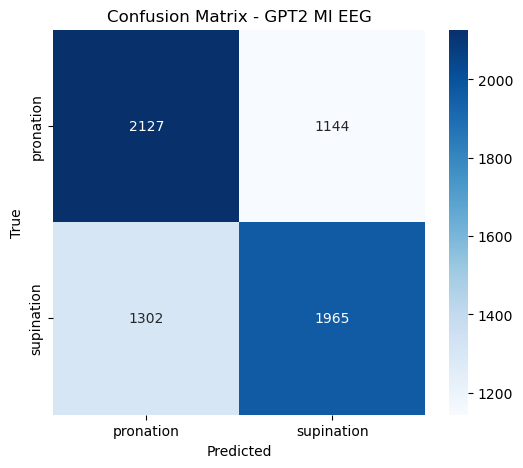

In [15]:
#Evaluation

# Load fine-tuned GPT2
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import load_dataset

# Load model + tokenizer
model_path = "./gpt2_mi_eeg/checkpoint-4090"  # adjust to your final checkpoint folder!
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

model = GPT2ForSequenceClassification.from_pretrained(model_path)
model.config.pad_token_id = tokenizer.pad_token_id
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load test dataset
dataset = load_dataset("text", data_files={"test": "gpt3_training_data.txt"})

# Preprocess
def preprocess(example):
    token_str, label = example["text"].split("\t")
    inputs = tokenizer(token_str, truncation=True, padding="max_length", max_length=128)
    inputs["labels"] = int(label)
    return inputs

dataset = dataset.map(preprocess)

# Run evaluation
all_preds = []
all_labels = []

for example in dataset["test"]:
    input_ids = torch.tensor(example["input_ids"]).unsqueeze(0).to(device)
    attention_mask = torch.tensor(example["attention_mask"]).unsqueeze(0).to(device)
    label = example["labels"]

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1).cpu().item()

    all_preds.append(pred)
    all_labels.append(label)

# Compute metrics
acc = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=["pronation", "supination"])

print(f"\nTest Accuracy: {acc:.4f}")
print("Classification Report:\n", report)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["pronation", "supination"], yticklabels=["pronation", "supination"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - GPT2 MI EEG")
plt.show()


In [ ]:
#Further Improvement - Replace K-Means with VQ-VAE Tokenization

In [7]:
#VQ-VAE Module

import torch
import torch.nn as nn
import torch.nn.functional as F

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)

    def forward(self, z):
        # Flatten input
        z_flattened = z.view(-1, self.embedding_dim)

        # Compute distances
        distances = (torch.sum(z_flattened**2, dim=1, keepdim=True)
                     + torch.sum(self.embeddings.weight**2, dim=1)
                     - 2 * torch.matmul(z_flattened, self.embeddings.weight.t()))

        # Get encoding indices
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=z.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize
        quantized = torch.matmul(encodings, self.embeddings.weight).view(z.shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), z)
        q_latent_loss = F.mse_loss(quantized, z.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Straight-through estimator
        quantized = z + (quantized - z).detach()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        #return loss, quantized, perplexity, encoding_indices.view(z.shape[0], z.shape[1])
        return loss, quantized, perplexity, encoding_indices.squeeze()



In [8]:
# Stack all MAE encoder outputs into one big array
all_features_np = np.vstack(all_features)
print(all_features_np.shape)  # Example: (N_samples * pool_T, 128)


(104608, 128)


In [9]:
#MAE Encoder Outputs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define VQ layer
vq_layer = VectorQuantizer(num_embeddings=256, embedding_dim=128, commitment_cost=0.25)
vq_layer = vq_layer.to(device)

optimizer = torch.optim.Adam(vq_layer.parameters(), lr=1e-3)

# Prepare features
features_tensor = torch.tensor(all_features_np).float().to(device)  # (N_samples * pool_T, emb_dim)
#features_tensor = features_tensor.view(-1, 1, 128)  # (N, 1, embedding_dim) → VQ expects batch x T x emb_dim
features_tensor = features_tensor.view(-1, 128)  # (N_samples, emb_dim)

# Simple training loop
batch_size = 512
n_epochs = 10

for epoch in range(n_epochs):
    permutation = torch.randperm(features_tensor.size(0))
    epoch_loss = 0

    for i in range(0, features_tensor.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch = features_tensor[indices].squeeze(1)

        optimizer.zero_grad()
        loss, quantized, perplexity, indices = vq_layer(batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {epoch_loss:.4f}")


Epoch 1/10 - Loss: 55.1553
Epoch 2/10 - Loss: 27.9952
Epoch 3/10 - Loss: 16.2050
Epoch 4/10 - Loss: 11.3015
Epoch 5/10 - Loss: 9.2904
Epoch 6/10 - Loss: 8.4932
Epoch 7/10 - Loss: 8.1784
Epoch 8/10 - Loss: 8.0593
Epoch 9/10 - Loss: 8.0160
Epoch 10/10 - Loss: 7.9943


In [10]:
torch.save(vq_layer.state_dict(), "vqvae_model.pth")
print("✅ VQ model saved!")


✅ VQ model saved!


In [11]:
#Extract Tokens

# Load trained VQ layer
vq_layer.load_state_dict(torch.load("vqvae_model.pth"))
vq_layer.eval()

# Extract tokens per trial → list of token sequences
token_sequences = []

for z in all_features:  # z: shape (pool_T, emb_dim)
    z_tensor = torch.tensor(z).float().to(device)
    with torch.no_grad():
        loss, quantized, perplexity, indices = vq_layer(z_tensor)
    tokens = indices.cpu().numpy().tolist()  # One token per timestep
    token_sequences.append(tokens)

print(f"✅ Extracted {len(token_sequences)} token sequences!")


✅ Extracted 6538 token sequences!


In [12]:
# Save token sequences to text file for GPT2
with open("gpt3_training_data_vqvae.txt", "w") as f:
    for tokens, label in zip(token_sequences, all_labels):
        token_str = " ".join([str(t) for t in tokens])
        label_str = str(label)
        f.write(f"{token_str}\t{label_str}\n")


In [22]:
pip install transformers==4.38.0

Note: you may need to restart the kernel to use updated packages.


In [13]:
#Optimized Training Arguments

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./gpt2_mi_eeg",
    #evaluation_strategy="epoch",   # Evaluate every epoch
    learning_rate=5e-5,            # Good starting LR for GPT2
    per_device_train_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    warmup_steps=500,              # Warmup important for small data
    lr_scheduler_type="cosine",    # Cosine LR helps GPT2 fine-tune better
    logging_steps=100,             # More frequent logging
    save_strategy="epoch",         # Save every epoch
)


In [14]:
#Layer Freezing

# Freeze lower 6 layers initially
for name, param in model.named_parameters():
    if "transformer.h." in name and int(name.split(".")[2]) < 6:
        param.requires_grad = False


In [15]:
#Token Augmentation

def augment_tokens(tokens, mask_prob=0.1, shift_prob=0.1, vocab_size=256):
    new_tokens = tokens.copy()

    # Random masking
    for i in range(len(new_tokens)):
        if np.random.rand() < mask_prob:
            new_tokens[i] = np.random.randint(0, vocab_size)

    # Local shifts
    if np.random.rand() < shift_prob and len(new_tokens) >= 5:
        start = np.random.randint(0, len(new_tokens)-5)
        segment = new_tokens[start:start+5]
        np.random.shuffle(segment)
        new_tokens[start:start+5] = segment

    return new_tokens


In [35]:
#Doesn't have __key__
def preprocess(example):
    token_str, label = example["text"].split("\t")
    tokens = [int(t) for t in token_str.split(" ")]

    # Apply augmentation (during training only)
    if "train" in example["__key__"] or "train" in example.get("split", ""):
        tokens = augment_tokens(tokens, mask_prob=0.1, shift_prob=0.1)

    token_str_aug = " ".join([str(t) for t in tokens])
    inputs = tokenizer(token_str_aug, truncation=True, padding="max_length", max_length=128)
    inputs["labels"] = int(label)
    return inputs


In [16]:
#Don't use yet!!!
def preprocess(example):
    token_str, label = example["text"].split("\t")
    tokens = [int(t) for t in token_str.split(" ")]

    tokens = augment_tokens(tokens, mask_prob=0.1, shift_prob=0.1)  # Always augment

    token_str_aug = " ".join([str(t) for t in tokens])
    inputs = tokenizer(token_str_aug, truncation=True, padding="max_length", max_length=128)
    inputs["labels"] = int(label)
    return inputs


In [22]:
pip show accelerate

Name: accelerate
Version: 1.7.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /home/e19249/miniconda3/envs/myenv/lib/python3.9/site-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install --upgrade accelerate

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip uninstall transformers accelerate huggingface-hub -y

Found existing installation: transformers 4.38.0
Uninstalling transformers-4.38.0:
  Successfully uninstalled transformers-4.38.0
Found existing installation: accelerate 1.7.0
Uninstalling accelerate-1.7.0:
  Successfully uninstalled accelerate-1.7.0
Found existing installation: huggingface-hub 0.32.5
Uninstalling huggingface-hub-0.32.5:
  Successfully uninstalled huggingface-hub-0.32.5
Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install transformers==4.38.0 accelerate==0.21.0 huggingface-hub==0.20.3

  Using cached transformers-4.38.0-py3-none-any.whl.metadata (131 kB)
Using cached transformers-4.38.0-py3-none-any.whl (8.5 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires huggingface-hub>=0.24.0, but you have huggingface-hub 0.20.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install datasets==2.18.0

  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
  Attempting uninstall: datasets
    Found existing installation: datasets 3.6.0
    Uninstalling datasets-3.6.0:
      Successfully uninstalled datasets-3.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.7.1+cu118 requires torch==2.7.1, but you have torch 2.6.0 which is incompatible.
torchvision 0.22.1+cu118 requires torch==2.7.1, but you have torch 2.6.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install torch==2.1.2 torchvision==0.16.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB ? eta 0:00:00 0:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 5.0 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB ? eta 0:00:00 0:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 5.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 4.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB ? eta 0:00:00 0:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 5.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [18]:
pip install transformers==4.38.0 accelerate==0.21.0 huggingface-hub==0.20.3

Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install datasets==2.18.0 scikit-learn==1.3.0 matplotlib==3.7.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 5.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 5.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  You can safely remove it manually.
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.9.2
    Uninstalling matplotlib-3.9.2:
      Successfully uninstalled matplotlib-3.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.3.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [20]:
from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments

# Prepare dataset
dataset = load_dataset("text", data_files={"train": "gpt3_training_data_vqvae.txt"})

# Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT2 doesn't have padding by default

# Apply preprocessing
dataset = dataset.map(preprocess)

# Load model
from transformers import GPT2ForSequenceClassification

model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)
model.config.pad_token_id = tokenizer.pad_token_id

# Freeze lower layers (before Trainer)
for name, param in model.named_parameters():
    if "transformer.h." in name and int(name.split(".")[2]) < 6:
        param.requires_grad = False

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
)

# Train
trainer.train()

# Next: Unfreeze all layers and run another 5 or 10 epochs and continue training
# Then re-run trainer.train() again with unfrozen model


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: __init__() got an unexpected keyword argument 'use_seedable_sampler'

In [ ]:
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Define a new TrainingArguments:
training_args_2 = TrainingArguments(
    output_dir="./gpt2_mi_eeg_unfreeze",
    #evaluation_strategy="epoch",
    learning_rate=3e-5,             # Slightly lower LR for fine-tuning full model
    per_device_train_batch_size=16,
    num_train_epochs=5,             # Another 5/10 epochs
    weight_decay=0.01,
    warmup_steps=300,
    lr_scheduler_type="cosine",
    logging_steps=100,
    save_strategy="epoch",
)

# New Trainer with unfrozen model
trainer_2 = Trainer(
    model=model,
    args=training_args_2,
    train_dataset=dataset["train"],
)

# Continue training → all layers now unfrozen
trainer_2.train()
